In [8]:
import torch
import numpy as np

from collections import defaultdict
from fugw_solver.utils import init_test_distribution

from fugw_solver.solver import solver

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

from mpl_toolkits.mplot3d.art3d import Line3DCollection

torch.manual_seed(0)
device = torch.device("cpu")

In [9]:
n_points_source = 50
n_points_target = 40
n_features = 2

source_features, source_geometry, source_embeddings =  init_test_distribution(n_features, n_points_source)

target_features, target_geometry, target_embeddings = init_test_distribution(n_features, n_points_target)


source_features_normalized = source_features / torch.linalg.norm(
    source_features, dim=1
).reshape(-1, 1)
target_features_normalized = target_features / torch.linalg.norm(
    target_features, dim=1
).reshape(-1, 1)

source_geometry_normalized = source_geometry / source_geometry.max()
target_geometry_normalized = target_geometry / target_geometry.max()

In [10]:
# We take uniform weights
w_s = torch.ones(source_features_normalized.shape[1], device=device) / source_features_normalized.shape[1]
w_t = torch.ones(target_features_normalized.shape[1], device=device) / target_features_normalized.shape[1]

alpha = 0.5
rho = 1
eps = 1e-4

P, loss_ls = solver(
    source_features=source_features_normalized,
    target_features=target_features_normalized,
    source_geometry=source_geometry_normalized,
    target_geometry=target_geometry_normalized,
    w_s=w_s,
    w_t=w_t,
    device=device,
    alpha=alpha,
    rho=rho,
    eps=eps,
    nits_bcd=10,
    nits_uot=1000
)

In [11]:
print(f"Transport plan's total mass: {P.sum():.5f}")

Transport plan's total mass: 0.99782


In [12]:
loss = defaultdict(list)
for l in loss_ls:
    for k,v in l.items():
        loss[k].append(v)

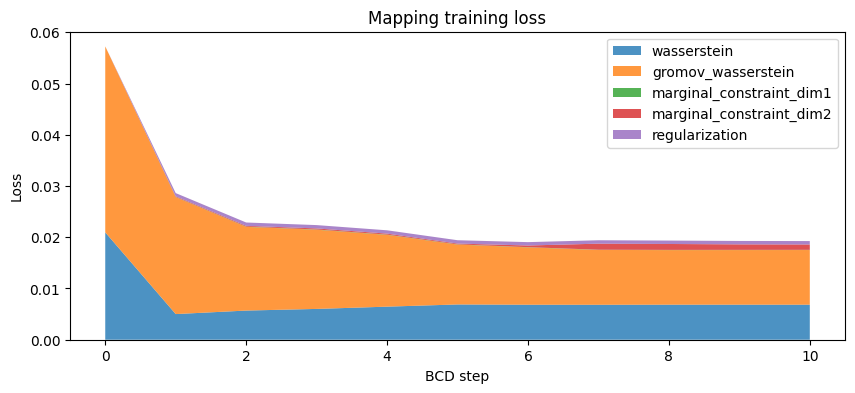

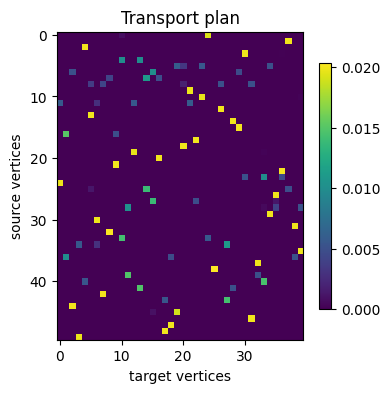

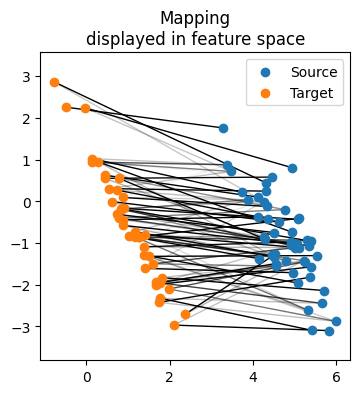

In [13]:
# %%
# The transport plan can be accessed after the model has been fitted
# %%
# Here is the evolution of the FUGW loss during training,
# as well as the contribution of each loss term:

fig, ax = plt.subplots(figsize=(10, 4))
ax.set_title("Mapping training loss")
ax.set_ylabel("Loss")
ax.set_xlabel("BCD step")
ax.stackplot(
    np.arange(len(loss_ls)),
    [
        (1 - alpha) * np.array(loss["wasserstein"]),
        alpha * np.array(loss["gromov_wasserstein"]),
        rho * np.array(loss["marginal_constraint_dim1"]),
        rho * np.array(loss["marginal_constraint_dim2"]),
        eps * np.array(loss["regularization"]),
    ],
    labels=[
        "wasserstein",
        "gromov_wasserstein",
        "marginal_constraint_dim1",
        "marginal_constraint_dim2",
        "regularization",
    ],
    alpha=0.8,
)
ax.legend()
plt.show()

# %%
# Using the computed mapping
# --------------------------
# The computed mapping is stored in ``mapping.pi`` as a ``torch.Tensor``.
# In this example, the transport plan is small enough that we can display
# it altogether.

fig, ax = plt.subplots(figsize=(4, 4))
ax.set_title("Transport plan")
ax.set_xlabel("target vertices")
ax.set_ylabel("source vertices")
im = plt.imshow(P, cmap="viridis")
plt.colorbar(im, ax=ax, shrink=0.8)
plt.show()

# %%
# The previous figure of the transport plan tells us it is very sparse
# and not very regularized.
# Another informative way to look at the plan consists in checking
# which points of the source and target distributions
# were matched together in the feature space.

fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot()
ax.set_aspect("equal", "datalim")
ax.set_title("Mapping\ndisplayed in feature space")

# Draw lines between matched points
indices = torch.cartesian_prod(
    torch.arange(n_points_source), torch.arange(n_points_target)
)
segments = torch.stack(
    [
        source_features[:, indices[:, 0]],
        target_features[:, indices[:, 1]],
    ]
).permute(2, 0, 1)
pi_normalized = P / P.sum(dim=1).reshape(-1, 1)
line_segments = LineCollection(
    segments, alpha=pi_normalized.flatten(), colors="black", lw=1, zorder=1
)
ax.add_collection(line_segments)

# Draw distributions
ax.scatter(source_features[0], source_features[1], label="Source")
ax.scatter(target_features[0], target_features[1], label="Target")

ax.legend()
plt.show()

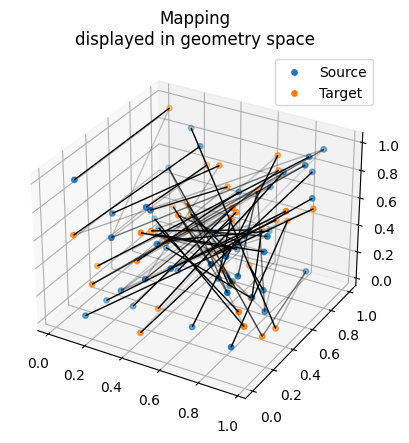

In [14]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.set_title("Mapping\ndisplayed in geometry space")
ax.scatter(
    source_embeddings[:, 0],
    source_embeddings[:, 1],
    source_embeddings[:, 2],
    s=15,
    label="Source",
)
ax.scatter(
    target_embeddings[:, 0],
    target_embeddings[:, 1],
    target_embeddings[:, 2],
    s=15,
    label="Target",
)
# Draw lines between matched points
indices = torch.cartesian_prod(
    torch.arange(n_points_source), torch.arange(n_points_target)
)

segments = torch.stack(
    [
        source_embeddings.permute(1,0)[:, indices[:, 0]],
        target_embeddings.permute(1,0)[:, indices[:, 1]],
    ]
).permute(2, 0, 1)

pi_normalized = P / P.sum(dim=1).reshape(-1, 1)

line_segments = Line3DCollection(segments, alpha=pi_normalized.flatten(), colors="black", lw=1, zorder=1)

ax.add_collection(line_segments)
ax.legend()
plt.show()